导入包并设置log等级

```os.environ["TF_CPP_MIN_LOG_LEVEL"]='1' # 这是默认的显示等级，显示所有信息
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2' # 只显示 warning 和 Error 
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3' # 只显示 Error```

In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99" # 设置LOG等级，越大越严

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() # 设备信息 查看设备资源

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17556438821071312231]

#### 指定GPU问题
如果一个 TensorFlow 的 operation 中兼有 CPU 和 GPU 的实现, 当这个算子被指派设备时, GPU 有优先权. 
比如matmul中 CPU 和 GPU kernel 函数都存在. 那么在 cpu:0 和 gpu:0 中, matmul operation 会被指派给 gpu:0 .

记录设备指派情况
为了获取你的 operations 和 Tensor 被指派到哪个设备上运行, 用 log_device_placement 新建一个 session, 并设置为 True.

使用多个 GPU
如果你想让 TensorFlow 在多个 GPU 上运行, 你可以建立 multi-tower 结构, 在这个结构 里每个 tower 分别被指配给不同的 GPU 运行. 比如:

```
c = []
for d in ['/gpu:2', '/gpu:3']:
  with tf.device(d):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
    c.append(tf.matmul(a, b))
with tf.device('/cpu:0'):
  sum = tf.add_n(c)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# 运行这个op.
print sess.run(sum)```

In [3]:
# Test with a simple computation
import tensorflow as tf

tf.Session()

# 指定运行的设备
with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
# If you have gpu you can try this line to compute b with your GPU
#with tf.device('/gpu:0'):    
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
# 要找出您的指令和张量被分配到哪个设备，请创建会话并将 log_device_placement 配置选项设为 True
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(sess.run(c))

# Runs the op.
# Log information
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run(c, options=options, run_metadata=metadata)

print(metadata.partition_graphs)

sess.close()

[[22. 28.]
 [49. 64.]]
[node {
  name: "_retval_MatMul_0_0"
  op: "_Retval"
  input: "MatMul/_0__cf__0"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
}
node {
  name: "MatMul/_0__cf__0"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
}
library {
}
versions {
  producer: 27
}
]


In [20]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

train = pd.read_csv('../input/HousePrice/train.csv')
print('Shape of the train data with all features:', train.shape)
# 选择数字格式的字段
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

test = pd.read_csv('../input/HousePrice/test.csv')
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


### 孤立森林 异常检测

定义：假设TT是孤立树的一个节点，它要么是没有子节点的叶子节点，要么是只有两个子节点(Tl,Tr)(Tl,Tr)的内部节点。每一步分割，都包含特征qq和分割值pp，将q<pq<p的数据分到TlTl，将q≥pq≥p的数据分到TrTr。

给定nn个样本数据X={x1,⋯,xn}X={x1,⋯,xn}，特征的维度为dd。为了构建一棵孤立树，需要随机选择一个特征qq及其分割值pp，递归地分割数据集XX，直到满足以下任意一个条件：(1)树达到了限制的高度；(2)节点上只有一个样本；(3)节点上的样本所有特征都相同。

异常检测的任务是给出一个反应异常程度的排序，常用的排序方法是根据样本点的路径长度或异常得分来排序，异常点就是排在最前面的那些点。

算法基本上不需要配置参数就可以直接使用，通常就以下几个(参数明显比随机森林简单)：

n_estimators: 默认为100，配置iTree树的多少

max_samples: 默认为256，配置采样大小

max_features: 默认为全部特征，对高维数据，可以只选取部分特征


通俗解释就是——建100棵iTree，每棵iTree最高n层，且每棵iTree都是独立随机选择256个数据样本建成。

In [32]:
# 孤立森林 异常检测
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [6]:
train.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


In [8]:
# 处理清洗
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [9]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

In [10]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.176471,0.159744,0.055205,0.375,0.142857,0.527132,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.636364,0.00,0.130767
433,0.588235,0.102236,0.028107,0.500,0.428571,0.914729,0.800000,0.07250,0.528892,0.0,...,0.000000,0.343407,0.0,0.0,0.0,0.0,0.000000,0.363636,0.00,0.299493
1110,0.823529,0.115016,0.011665,0.625,0.428571,0.953488,0.883333,0.06625,0.000000,0.0,...,0.000000,0.074176,0.0,0.0,0.0,0.0,0.000000,0.454545,1.00,0.326257


In [11]:
# Deep Neural Network for continuous features
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [12]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [14]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [15]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x0000016B9CDEBAC8>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn

In [16]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [17]:
# Display the score on the testing set
# 0.002X in average 
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.002529


In [18]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

In [21]:
# Predictions and submission
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1)),columns = ['Prediction'])
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice

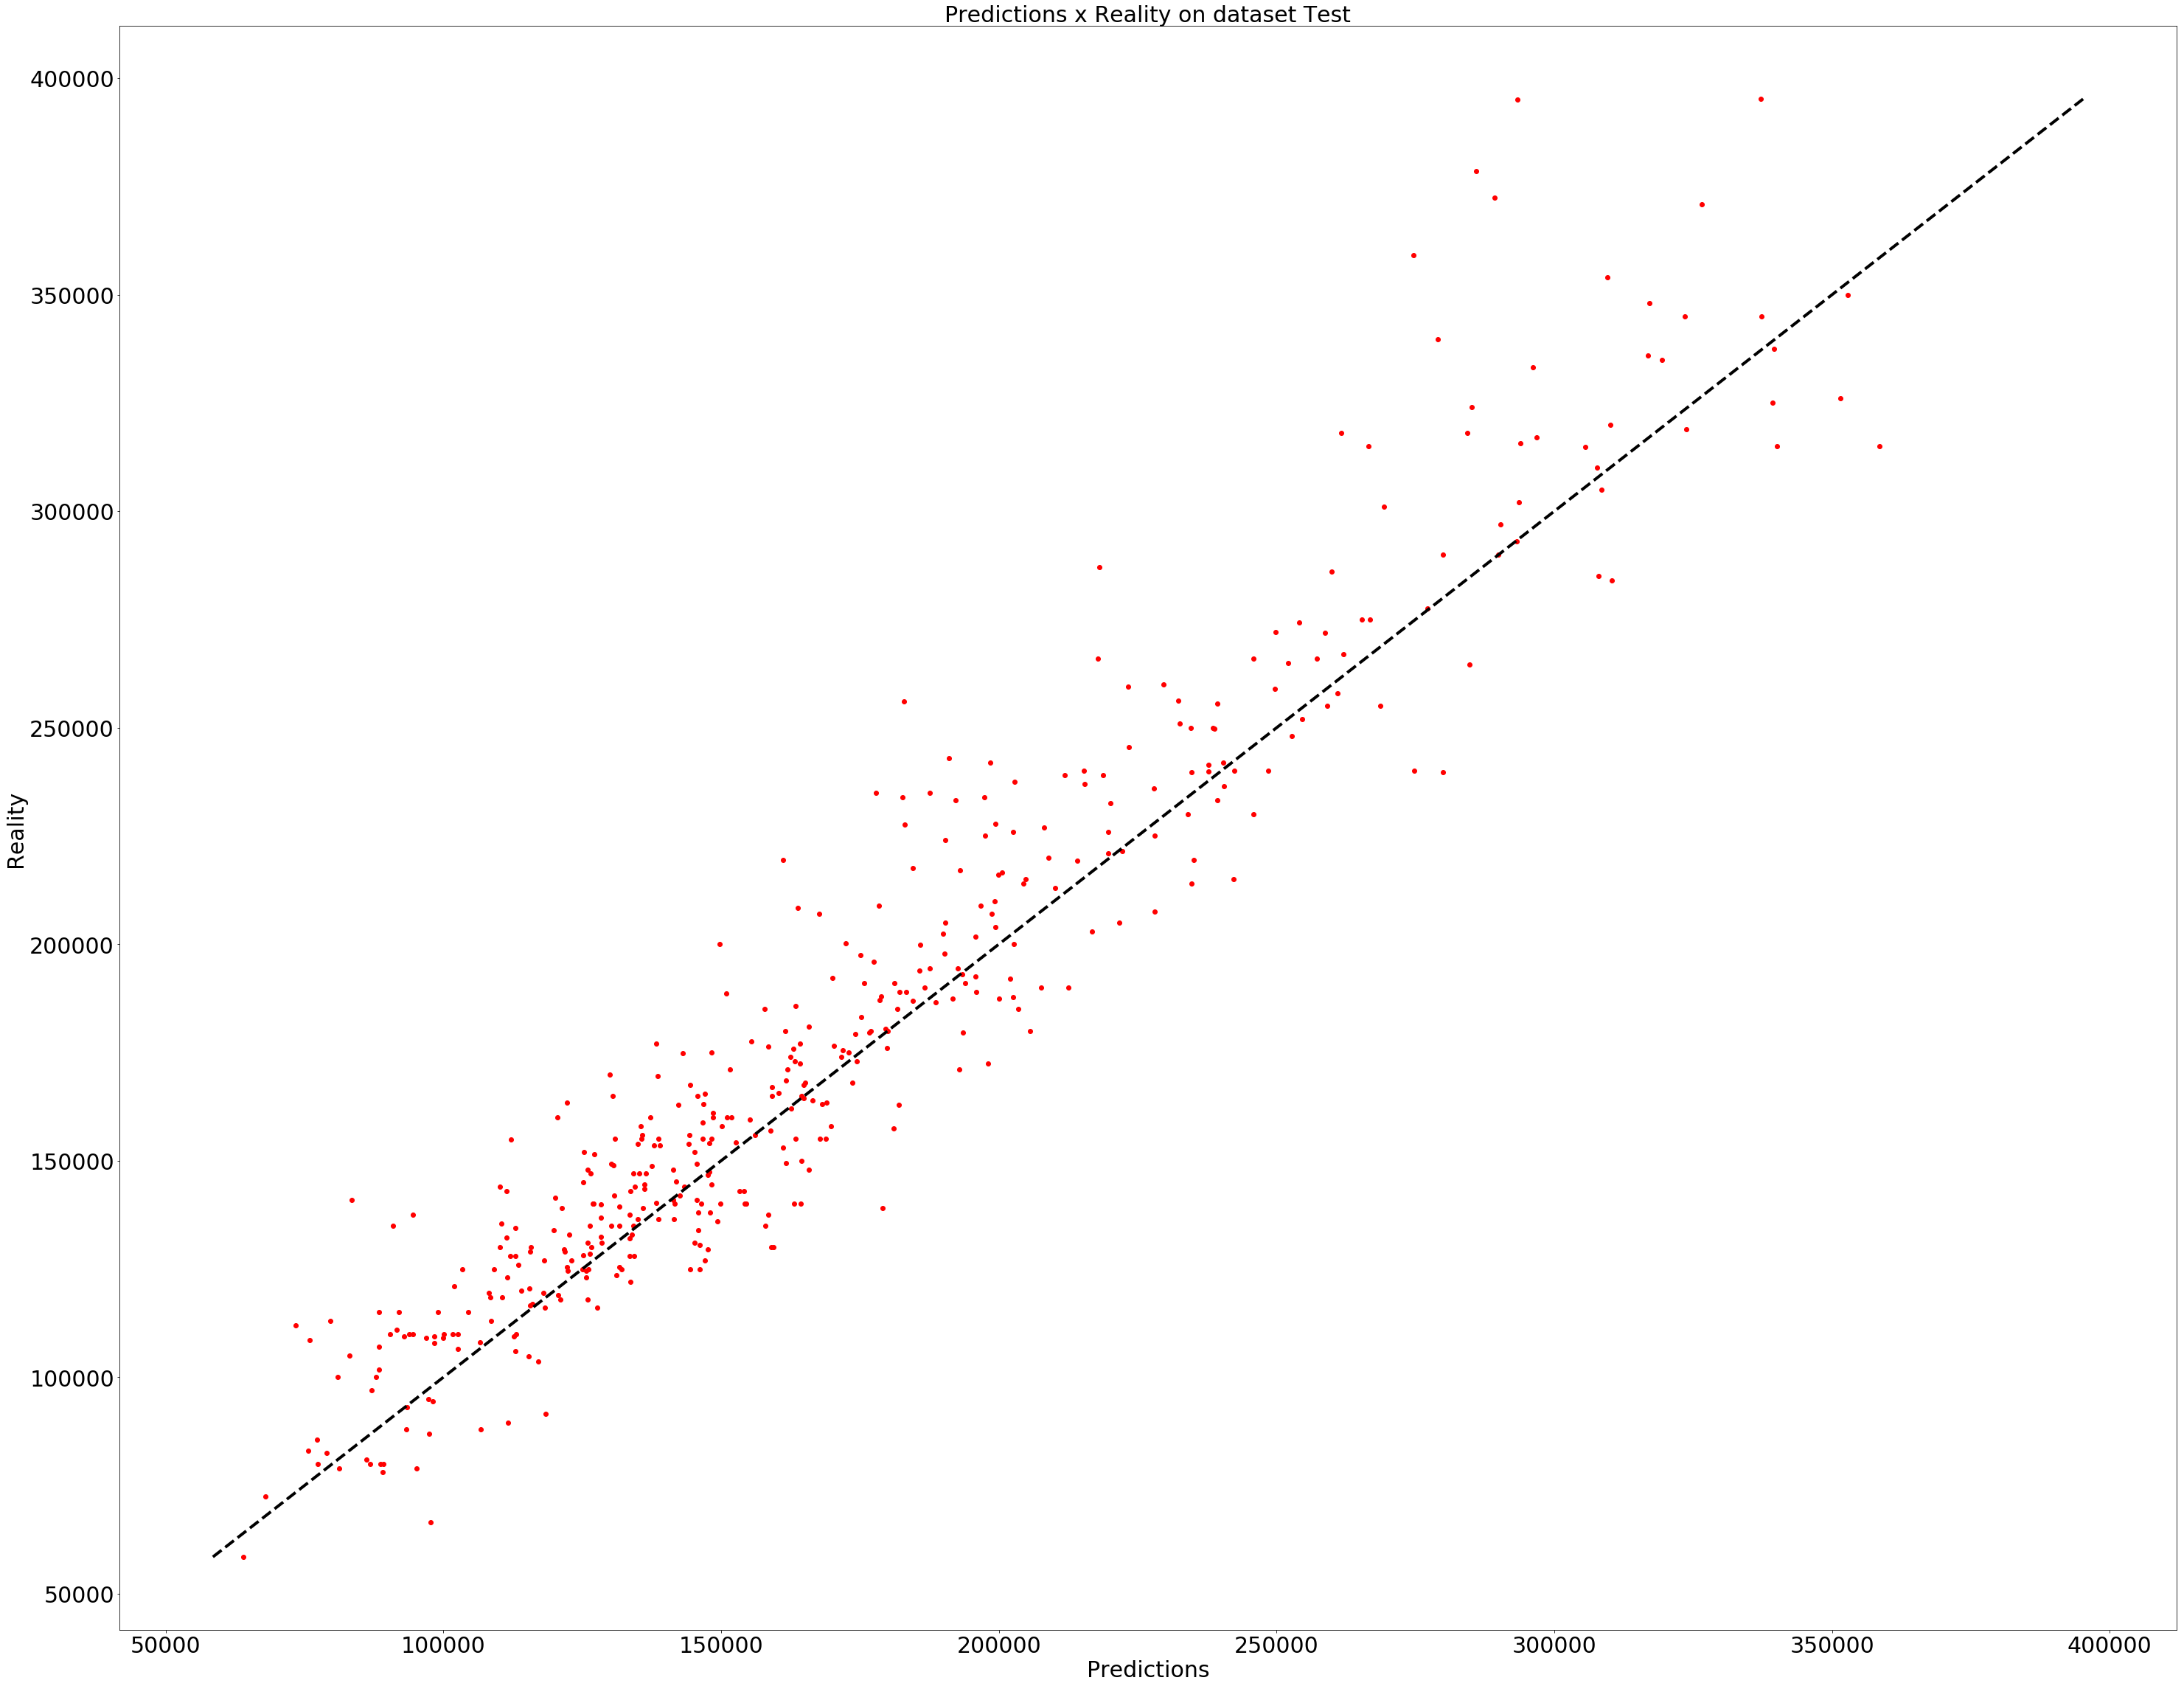

In [22]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()


In [23]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpcppqdlrz\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [24]:
# Leaky Relu 激活函数
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)


In [25]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016B9EA236A0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'D:\\Users\\hw_liu\\AppData\\Local\\Temp\\tmpc57_0m_f'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into D:\Users\hw_liu\AppData\Local\Temp\tmpc57_0m_f\model.ckpt.
INFO:tensorflow:loss = 0.13829346, step = 1
INFO:tensorflow:global_step/sec: 149.656
INFO:tensorflow:loss = 0.0050288066, step = 101 (0.670 sec)
INFO:tensorflow:global_step/sec: 151.005
INFO:tensorflow:loss = 0.0037486255, step = 201 (0.662 sec)
INFO:tensorflow:global_step/sec: 150.551
INFO:tensorflow:loss = 0.0032137313, step = 301 (0.664 sec)
INFO:tensorflow:global_step/sec: 156.424
INFO:tensorflow:loss = 0.002757723, step = 401 (0.639 sec)
INFO:tensorflow:global_step/sec: 166.278
INFO:tensorflow:loss = 0.0026729489, step = 501 (0.601 sec)
INFO:tensorflow:global_step/sec: 176.842
INFO:tensorflow:loss = 0.0024430712, step = 601 (0.565 sec)
INFO:tensorflow:global_step/sec: 168.516
INFO:tensorflow:loss = 0.0023044774, step

INFO:tensorflow:Starting evaluation at 2019-06-19-08:33:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpc57_0m_f\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-19-08:33:10
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.0024470347


In [26]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

Final Loss on the testing set with Leaky Relu: 0.002447


In [27]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Leaky_relu")

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpc57_0m_f\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [28]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev["loss"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016BA5FE3048>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'D:\\Users\\hw_liu\\AppData\\Local\\Temp\\tmpgcqz0etj'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into D:\Users\hw_liu\AppData\Local\Temp\tmpgcqz0etj\model.ckpt.
INFO:tensorflow:loss = 0.1673001, step = 1
INFO:tensorflow:global_step/sec: 178.73
INFO:tensorflow:loss = 0.004502397, step = 101 (0.561 sec)
INFO:tensorflow:global_step/sec: 207.164
INFO:tensorflow:loss = 0.0039282897, step = 201 (0.482 sec)
INFO:tensorflow:global_step/sec: 193.193
INFO:tensorflow:loss = 0.003931741, step = 301 (0.518 sec)
INFO:tensorflow:global_step/sec: 190.985
INFO:tensorflow:loss = 0.0039840965, step = 401 (0.525 sec)
INFO:tensorflow:global_step/sec: 210.204
INFO:tensorflow:loss = 0.0036579745, step = 501 (0.476 sec)
INFO:tensorflow:global_step/sec: 207.163
INFO:tensorflow:loss = 0.0034067896, step = 601 (0.483 sec)
INFO:tensorflow:global_step/sec: 182.97
INFO:tensorflow:loss = 0.003226667, step = 70

INFO:tensorflow:Starting evaluation at 2019-06-19-08:33:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpgcqz0etj\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-19-08:33:23
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.0022840502


In [29]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))

Final Loss on the testing set with Elu: 0.002284


In [30]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Elu")

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpgcqz0etj\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [33]:
# Deep Neural Network for continuous and categorical features
# Import and split
train = pd.read_csv('../input/HousePrice/train.csv')
train.drop('Id',axis = 1, inplace = True)
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)
train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True)
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 

test = pd.read_csv('../input/HousePrice/test.csv')
ID = test.Id
test.drop('Id',axis = 1, inplace = True)
test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)
test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True)
test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

In [34]:
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

In [35]:
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('SalePrice')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(1314,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

In [36]:
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

In [37]:
# List of features
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "SalePrice"

FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))
                                 
# Training set and Prediction set with the features to predict
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)

# Training for submission
training_sub = training_set[FEATURES + FEATURES_CAT]
testing_sub = test[FEATURES + FEATURES_CAT]

In [38]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test, left_index = True, right_index = True)

In [39]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)

def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016BA30F66D8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'D:\\Users\\hw_liu\\AppData\\Local\\Temp\\tmpc61vyf44'}


In [40]:
categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(training_set[k].size)], values = training_set[k].values, dense_shape = [training_set[k].size, 1]) for k in FEATURES_CAT}

In [41]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into D:\Users\hw_liu\AppData\Local\Temp\tmpc61vyf44\model.ckpt.
INFO:tensorflow:loss = 0.13710155, step = 1
INFO:tensorflow:global_step/sec: 27.921
INFO:tensorflow:loss = 0.0040683514, step = 101 (3.584 sec)
INFO:tensorflow:global_step/sec: 46.4169
INFO:tensorflow:loss = 0.0032425025, step = 201 (2.154 sec)
INFO:tensorflow:global_step/sec: 45.2643
INFO:tensorflow:loss = 0.0026553075, step = 301 (2.209 sec)
INFO:tensorflow:global_step/sec: 45.9911
INFO:tensorflow:loss = 0.002325752, step = 401 (2.174 sec)
INFO:tensorflow:global_step/sec: 46.3097
INFO:tensorflow:loss = 0.0021374084, step = 501 (2.159 sec)


INFO:tensorflow:global_step/sec: 43.5348
INFO:tensorflow:loss = 0.0020617258, step = 601 (2.297 sec)
INFO:tensorflow:global_step/sec: 46.8069
INFO:tensorflow:loss = 0.0018941836, step = 701 (2.136 sec)
INFO:tensorflow:global_step/sec: 45.7811
INFO:tensorflow:loss = 0.001800437, step = 801 (2.184 sec)
INFO:tensorflow:global_step/sec: 43.8585
INFO:tensorflow:loss = 0.0017191882, step = 901 (2.280 sec)
INFO:tensorflow:global_step/sec: 46.7633
INFO:tensorflow:loss = 0.0016391928, step = 1001 (2.138 sec)
INFO:tensorflow:global_step/sec: 45.97
INFO:tensorflow:loss = 0.001569138, step = 1101 (2.175 sec)
INFO:tensorflow:global_step/sec: 46.0756
INFO:tensorflow:loss = 0.0015190395, step = 1201 (2.170 sec)
INFO:tensorflow:global_step/sec: 45.3873
INFO:tensorflow:loss = 0.0014775541, step = 1301 (2.203 sec)
INFO:tensorflow:global_step/sec: 45.1827
INFO:tensorflow:loss = 0.0014315322, step = 1401 (2.213 sec)
INFO:tensorflow:global_step/sec: 46.0968
INFO:tensorflow:loss = 0.0014175838, step = 1501 

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x0000016BA30F6908>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn

In [42]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)

INFO:tensorflow:Starting evaluation at 2019-06-19-09:16:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpc61vyf44\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-19-09:16:21
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.0017704832


In [43]:
loss_score4 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score4))


Final Loss on the testing set: 0.001770


In [44]:
# Predictions bis
# Predictions
y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpc61vyf44\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


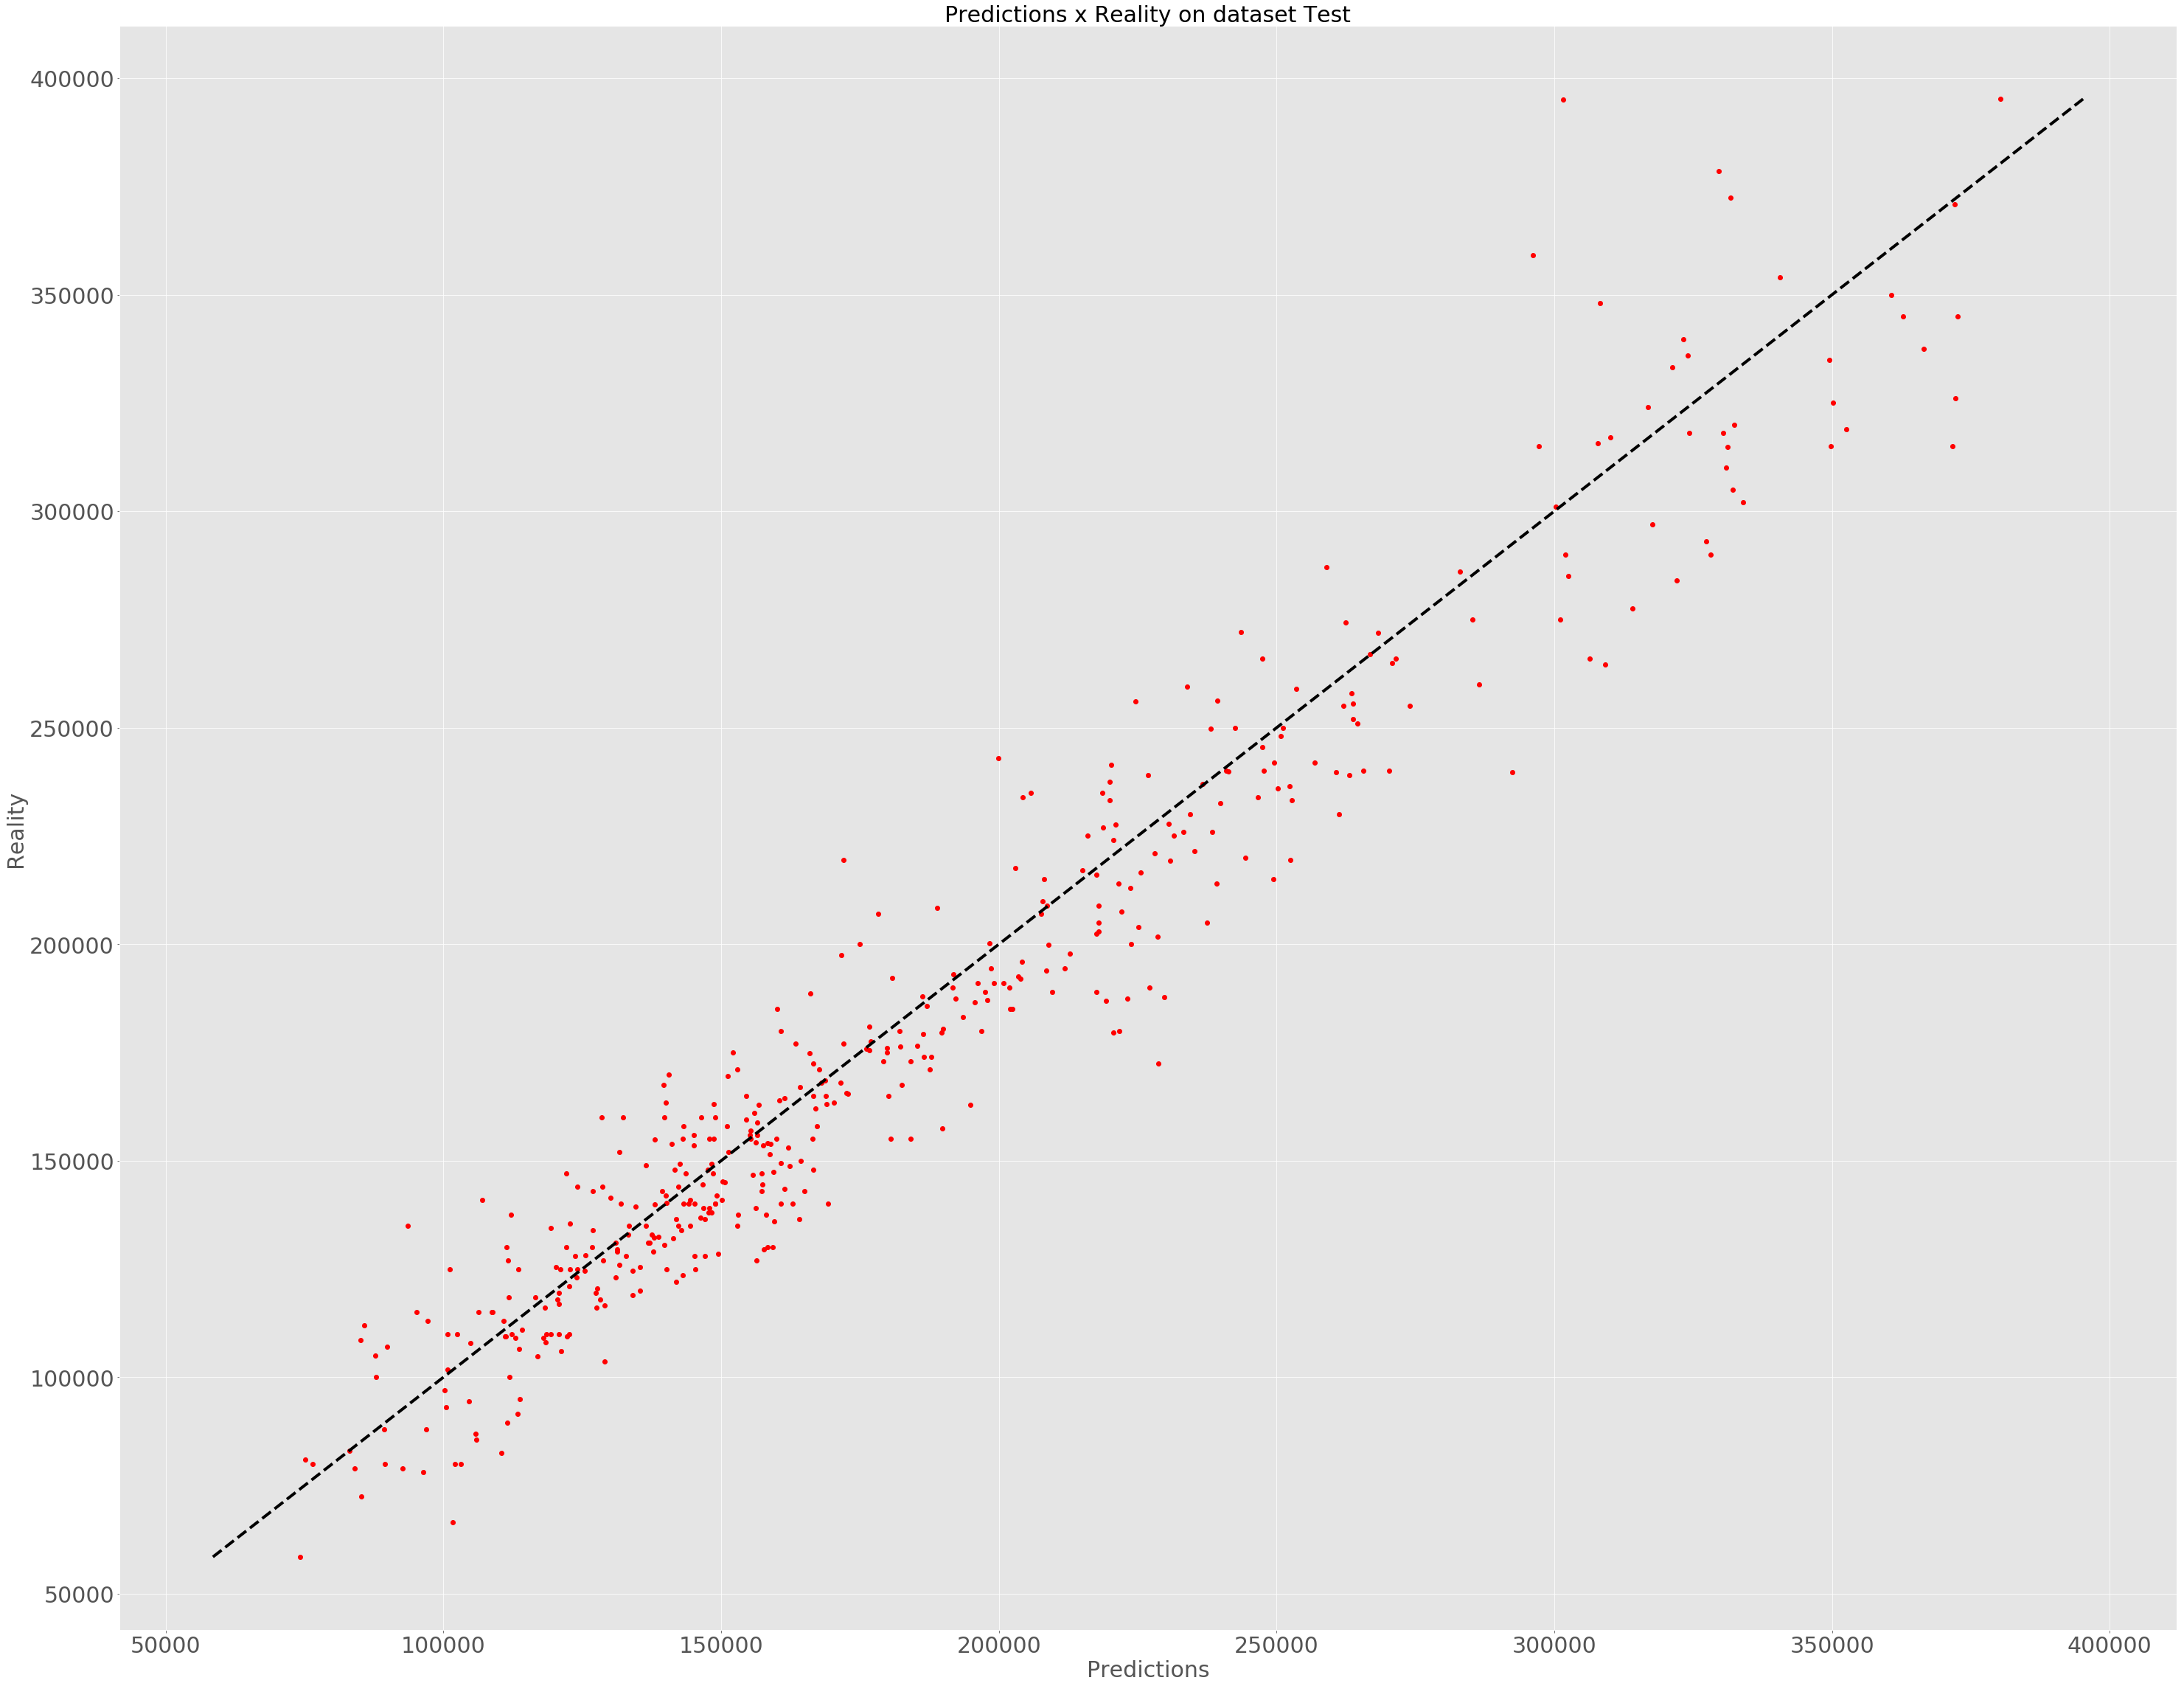

In [45]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [46]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))
to_submit(y_predict, "../output/HousePrice/submission_cont_categ")

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmpc61vyf44\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [47]:
# Shallow Network
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[1000])
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016BB2DDF5F8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'D:\\Users\\hw_liu\\AppData\\Local\\Temp\\tmp3v_kqgau'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into D:\Users\hw_liu\AppData\Local\Temp\tmp3v_kqgau\model.ckpt.
INFO:tensorflow:loss = 0.109799154, step = 1
INFO:tensorflow:global_step/sec: 15.8577
INFO:tensorflow:loss = 0.0027515618, step = 101 (6.307 sec)
INFO:tensorflow:global_step/sec: 16.8647
INFO:tensorflow:loss = 0.0021734522, step = 201 (5.930 sec)
INFO:tensorflow:global_step/sec: 18.5256
INFO:tensorflow:loss = 0.0018747132, step = 301 (5.397 sec)
INFO:tensorflow:global_step/sec: 19.5135
INFO:tensorflow:loss = 0.0016919144, step = 401 (5.127 sec)
INFO:tensorflow:global_step/sec: 19.6416
INFO:tensorflow:loss = 0.0015615604, step = 501 (5.090 sec)
INFO:tensorflow:global_step/sec: 20.3947
INFO:tensorflow:loss = 0.0014617632, step = 601 (4.903 sec)
INFO:tensorflow:global_step/sec: 20.4864
INFO:tensorflow:loss = 0.0013806049, st

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x0000016BB2E14DD8>, 'hidden_units': [1000], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Ma

In [48]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score5))

INFO:tensorflow:Starting evaluation at 2019-06-19-09:18:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmp3v_kqgau\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-19-09:18:26
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.0017546812
Final Loss on the testing set: 0.001755


In [49]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    
to_submit(y_predict, "../output/HousePrice/submission_shallow")

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Users\hw_liu\AppData\Local\Temp\tmp3v_kqgau\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [50]:
# Conclusion
list_score = [loss_score1, loss_score2, loss_score3, loss_score4,loss_score5]
list_model = ['Relu_cont', 'LRelu_cont', 'Elu_cont', 'Relu_cont_categ','Shallow_1ku']

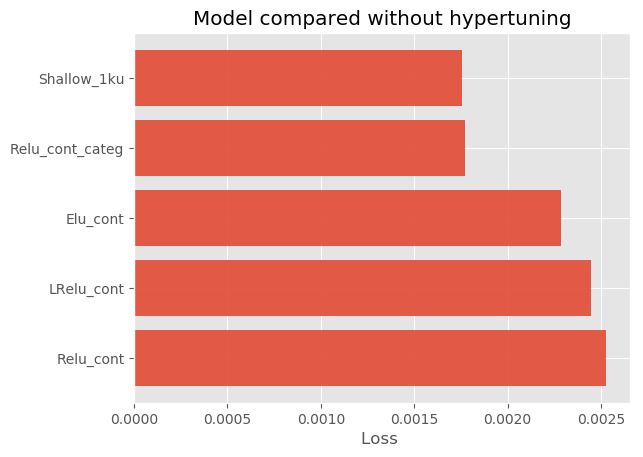

In [51]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.style.use('ggplot')
objects = list_model
y_pos = np.arange(len(objects))
performance = list_score
 
plt.barh(y_pos, performance, align='center', alpha=0.9)
plt.yticks(y_pos, objects)
plt.xlabel('Loss ')
plt.title('Model compared without hypertuning')
 
plt.show()

In [52]:
# So, I hope that this small introduction will be useful ! 
# With this code you can build a regression model with Tensorflow 
# with continuous and categorical features plus add a new activation function (LeakyRelu). 
# If you want to improve the results you can re-build the models on the whole of data. 
# You can see that I'm used just 67% of the training set to build my models.

# Take my code and play with it: More Hyperparameters, 100% of the training set to build the next models, 
# try with other activation function etc...